# Load synthetic data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [2]:
import tensorflow as tf
import keras as K
from keras.callbacks import EarlyStopping

In [3]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [4]:
class FeatureScaler(object):
    def __init__(self, train):
        self.mean = train.mean(axis=0)
        self.std = train.std(axis=0)
    
    def transform(self, df):
        return (df - self.mean) / self.std
    
    def inverse_transform(self, df):
        return df * self.std + self.mean
    
    def get_params(self):
        return self.mean, self.std

In [5]:
def build_nn(input_length, hidden_layer_sizes = [20, 10, 5]):
    model = K.models.Sequential()
    kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/input_length))
    model.add(K.layers.Dense(units=hidden_layer_sizes[0], activation='relu', kernel_initializer=kernel_init, 
                             input_shape=[input_length]))
    for layer_idx in range(1, len(hidden_layer_sizes)):
        kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/hidden_layer_sizes[layer_idx-1]))
        model.add(K.layers.Dense(units=hidden_layer_sizes[layer_idx], kernel_initializer=kernel_init, activation='relu'))
    kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/hidden_layer_sizes[-1]))
    model.add(K.layers.Dense(units=1, kernel_initializer=kernel_init, activation='linear'))
    return model

In [6]:
def train_nn(X_train, Y_train, X_val, Y_val, batch_size=128, n_epochs=50, hidden_layer_sizes=[20, 10, 5], verbose=1):
    n_features = X_train.shape[1]
    model = build_nn(n_features, hidden_layer_sizes)
    
    if verbose != 0:
        print("Neural Network Architechture:")
        print(model.summary())
        print('\n')
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=verbose, mode='auto', restore_best_weights=True)
    train_log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=verbose, 
                          validation_data=(X_val, Y_val), callbacks=[early_stopping])
    
    return model, train_log.history

In [7]:
def plot_learning_history(history):
    plt.figure()
    plt.plot(history['loss'], color='b', marker='o', label='train loss')
    plt.plot(history['val_loss'], color='r', marker='o', label='val loss')
    plt.xlabel("epochs")
    plt.ylabel('loss')
    plt.legend(loc=1)
    plt.show()

# Heston Model Neural Network

## Data Loading and preprocessing

Load generated synthetic data

In [9]:
train = pd.read_csv("./data/heston/ftse_0118_train.csv").dropna()
val = pd.read_csv("./data/heston/ftse_0118_val.csv").dropna()
test = pd.read_csv("./data/heston/ftse_0118_test.csv").dropna()

In [10]:
train.shape, val.shape, test.shape

((898447, 8), (59899, 8), (39942, 8))

In [11]:
train.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,iv
0,0.853775,0.105191,2.680211,0.510126,1.477005,-0.538846,0.852275,0.911190
1,0.995012,0.703600,2.533609,0.080052,4.435808,-0.130318,0.348018,0.288833
2,0.965748,0.250895,7.936174,0.379712,0.217746,-0.914235,0.690499,0.717129
3,0.963932,0.208531,8.842848,0.552372,2.840455,-0.500989,0.144454,0.575906
4,0.854585,0.494104,9.338207,0.725030,3.863376,-0.999472,0.257029,0.744499


Split input features and labels

In [12]:
X_train_origin, Y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_val_origin, Y_val = val.iloc[:, :-1], val.iloc[:, [-1]]
X_test_origin, Y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

In [13]:
X_train_origin.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0
0,0.853775,0.105191,2.680211,0.510126,1.477005,-0.538846,0.852275
1,0.995012,0.703600,2.533609,0.080052,4.435808,-0.130318,0.348018
2,0.965748,0.250895,7.936174,0.379712,0.217746,-0.914235,0.690499
3,0.963932,0.208531,8.842848,0.552372,2.840455,-0.500989,0.144454
4,0.854585,0.494104,9.338207,0.725030,3.863376,-0.999472,0.257029


In [14]:
Y_train.head()

,iv
0,0.911190
1,0.288833
2,0.717129
3,0.575906
4,0.744499


Normalize features

In [15]:
SCALER = FeatureScaler(X_train_origin)
X_train = SCALER.transform(X_train_origin)
X_val = SCALER.transform(X_val_origin)
X_test = SCALER.transform(X_test_origin)

In [16]:
X_train.shape, Y_train.shape

((898447, 7), (898447, 1))

In [17]:
X_train.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0
0,-1.385939,-1.084707,-0.802190,0.034601,-0.709696,-0.135119,1.218621
1,0.039946,1.065305,-0.853000,-1.455411,1.341621,1.281418,-0.526934
2,-0.255502,-0.561210,1.019429,-0.417222,-1.582731,-1.436749,0.658611
3,-0.273828,-0.713417,1.333666,0.180967,0.235574,-0.003853,-1.231599
4,-1.377759,0.312611,1.505348,0.779149,0.944758,-1.732303,-0.841904


## Neural Network

Define some hyper-parameters

In [18]:
# parameters
hidden_layer_sizes = [20, 10, 5]
batch_size = 128
n_epochs = 50

Build Neural Network, and train it

In [19]:
model, history = train_nn(X_train, Y_train, X_val, Y_val, batch_size, n_epochs, hidden_layer_sizes, verbose=1)

Neural Network Architechture:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
7020/7020 [==============================] - 14s 2ms/step - loss: 0.0456 - val_loss: 0.0011
Epoch 2/50
7020/7020 [==============================] - 13s 2ms/step - loss: 9.0175e-04 - val_loss: 5.1080e-04
Epoch

Plot learning history curve

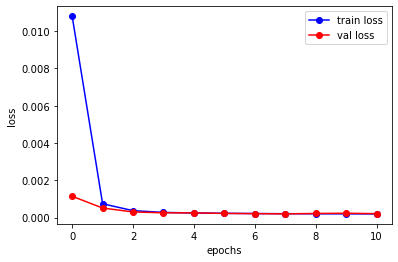

In [20]:
plot_learning_history(history)

Evaluate model performance on test dataset

In [21]:
model.evaluate(X_test, Y_test)

1249/1249 [==============================] - 1s 906us/step - loss: 1.9297e-04


0.00019297325343359262

Save model to local file for further use, or load a previously trained model

In [22]:
# from keras.models import load_model
# model = load_model('heston.h5')

model.save("heston.h5")

Study the quantiles of the relative error on test dataset

In [23]:
pred_test = model.predict(X_test).flatten()
true_test = Y_test.values.flatten()
relative_error = 100 * np.abs(pred_test - true_test) / true_test

In [24]:
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*len(relative_error))]
q_95 = sorted_re[int(0.95*len(relative_error))]
q_99 = sorted_re[int(0.99*len(relative_error))]

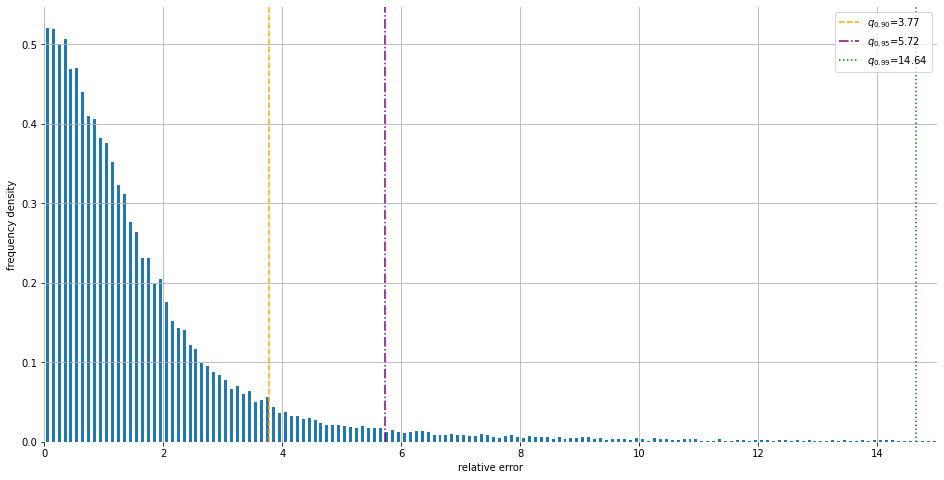

In [25]:
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 15, 151), density=True, rwidth=0.5)
plt.xlim((0, 15))
sns.despine(left=True, bottom=True, right=True)
plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange', label=r"$q_{0.90}$"+"={:.2f}".format(q_90))
plt.axvline(x=q_95, ls='-.', color='purple', label=r"$q_{0.95}$"+"={:.2f}".format(q_95))
plt.axvline(x=q_99, ls=':', color='green', label=r"$q_{0.99}$"+"={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

Use a fixed parameter to generate the IV surface

In [26]:
log_moneyness = np.linspace(-0.1, 0.1, 21)
maturity = np.linspace(0.01, 0.18, 18)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['Moneyness', 'Time to Maturity (years)', 'lambda', 'vbar', 'eta', 'rho', 'v0']
df = pd.DataFrame(columns=train.columns)
df['Moneyness'] = np.exp(log_moneyness.flatten())
df['Time to Maturity (years)'] = maturity.flatten()
df['eta'] = 0.3877
df['rho'] = -0.7165
df['lambda'] = 1.3253
df['v0'] = 0.0354
df['vbar'] = 0.0174

In [27]:
df.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,iv
0,0.904837,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN
1,0.913931,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN
2,0.923116,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN
3,0.932394,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN
4,0.941765,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN


In [30]:
from tqdm import tqdm
tqdm.pandas()

from utils import heston_pricer

In [29]:
df['iv'] = df.progress_apply(lambda row: heston_pricer(row['lambda'], row['vbar'], row['eta'], row['rho'], row['v0'], 
                                                       0, 0, row['Time to Maturity (years)'], 1.0, row['Moneyness'])[1], 
                             axis=1)

100%|██████████| 378/378 [00:00<00:00, 532.32it/s]


In [30]:
scaled_features = SCALER.transform(df.iloc[:, :-1])

In [31]:
df['iv_nn'] = model.predict(scaled_features)

In [32]:
df.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,iv,iv_nn
0,0.904837,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.231526,0.182480
1,0.913931,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.228294,0.176387
2,0.923116,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.224999,0.173076
3,0.932394,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.221641,0.169989
4,0.941765,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.218215,0.166816


In [33]:
df['Log Moneyness'] = log_moneyness.flatten()
df['re'] = np.abs(df['iv_nn'] - df['iv']) / df['iv']

In [38]:
def plot_heatmap(data, values='re'):
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot(index='Time to Maturity (years)', columns='Log Moneyness', values=values)
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap=plt.cm.Spectral, cbar=True, 
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

Plot the heatmap of relative errors

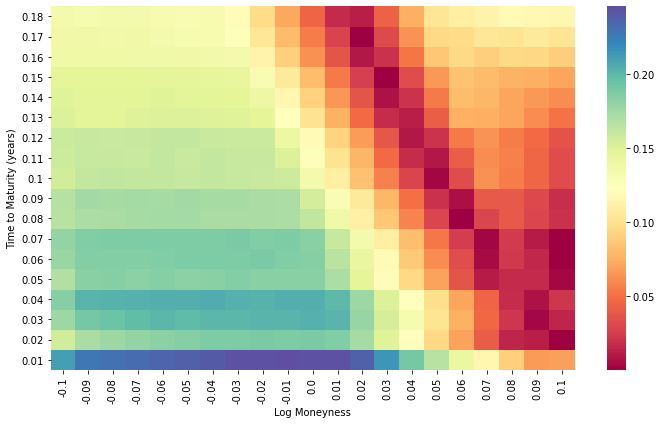

In [35]:
plot_heatmap(df, 're')

Plot IV surface

In [39]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca(projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()

Firstly, the "true" IV surface

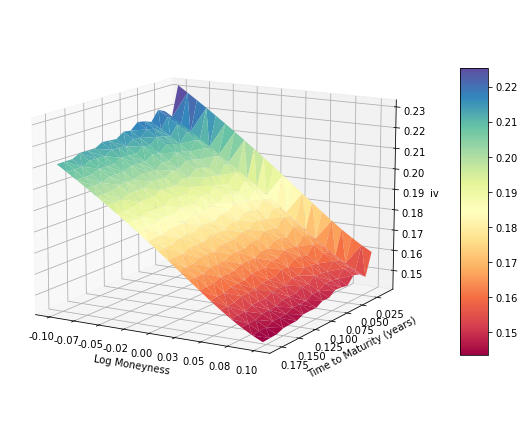

In [37]:
plot_iv_surface(df, z='iv')

Secondly, the "predicted" IV surface

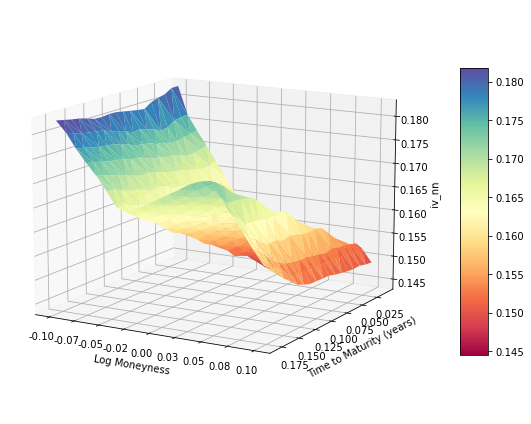

In [38]:
plot_iv_surface(df, z='iv_nn')

----------

----------

# rBergomi Model Neural Network

## Data Loading and preprocessing

Load generated synthetic data

In [8]:
train = pd.read_csv("./data/rBergomi/ftse_0118_train.csv").dropna()
val = pd.read_csv("./data/rBergomi/ftse_0118_val.csv").dropna()
test = pd.read_csv("./data/rBergomi/ftse_0118_test.csv").dropna()

In [9]:
train.shape, val.shape, test.shape

((263631, 9), (17560, 9), (11720, 9))

In [10]:
train = train.drop(columns=['label','index'])
val = val.drop(columns=['label','index'])
test = test.drop(columns=['label','index'])

In [11]:
train = train[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
val = val[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
test = test[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]

Split input features and labels

In [12]:
X_train_origin, Y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_val_origin, Y_val = val.iloc[:, :-1], val.iloc[:, [-1]]
X_test_origin, Y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

In [13]:
X_train_origin.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.119790,0.940696,0.041295,2.225799,-0.997984,0.165429
1,0.036204,0.947760,0.398704,1.647835,-0.836806,0.164353
2,0.154546,0.995318,0.266474,3.174934,-0.873824,0.114578
3,0.087680,0.965748,0.250895,2.512963,-0.878655,0.053254
4,0.111961,1.007250,0.310239,2.793560,-0.754466,0.108721


In [14]:
Y_train.head()

,iv
0,0.432710
1,0.391287
2,0.229422
3,0.207833
4,0.239667


Normalize features

In [15]:
SCALER = FeatureScaler(X_train_origin)
X_train = SCALER.transform(X_train_origin)
X_val = SCALER.transform(X_val_origin)
X_test = SCALER.transform(X_test_origin)

In [16]:
X_train.shape, Y_train.shape

((263631, 6), (263631, 1))

In [17]:
X_train.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.782763,-0.509980,-1.316150,-0.351555,-1.580655,1.428017
1,-1.122477,-0.438684,-0.031326,-1.585436,0.151045,1.405011
2,1.574964,0.041318,-0.506668,1.674728,-0.246680,0.340468
3,0.050864,-0.257134,-0.562674,0.261504,-0.298577,-0.971038
4,0.604307,0.161745,-0.349342,0.860542,1.035707,0.215226


## Neural Network

Define some hyper-parameters

In [18]:
# parameters
hidden_layer_sizes = [20, 10, 5]
batch_size = 128
n_epochs = 50

Build Neural Network and train it

In [19]:
model, history = train_nn(X_train, Y_train, X_val, Y_val, batch_size, n_epochs, hidden_layer_sizes, verbose=1)

Neural Network Architechture:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
2060/2060 [==============================] - 5s 2ms/step - loss: 0.5245 - val_loss: 0.0023
Epoch 2/50
2060/2060 [==============================] - 4s 2ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/50
2060

Plot learning history curve

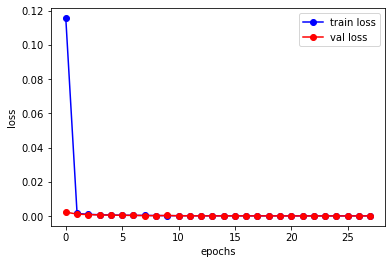

In [20]:
plot_learning_history(history)

Evaluate model performance on test dataset

In [21]:
model.evaluate(X_test, Y_test)

367/367 [==============================] - 0s 929us/step - loss: 1.2483e-04


0.00012482910824473947

Save model to local file for further use

In [22]:
model.save("rBergomi.h5")

Study the quantiles of the relative error on test dataset

In [23]:
pred_test = model.predict(X_test).flatten()
true_test = Y_test.values.flatten()
relative_error = 100 * np.abs(pred_test - true_test) / true_test

In [24]:
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*len(relative_error))]
q_95 = sorted_re[int(0.95*len(relative_error))]
q_99 = sorted_re[int(0.99*len(relative_error))]

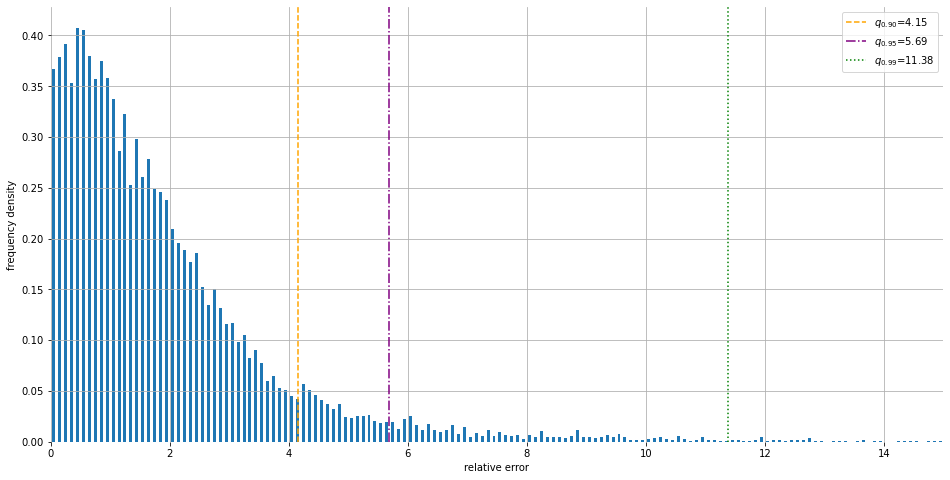

In [25]:
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 15, 151), density=True, rwidth=0.5)
plt.xlim((0, 15))
sns.despine(left=True, bottom=True, right=True)
plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange', label=r"$q_{0.90}$"+"={:.2f}".format(q_90))
plt.axvline(x=q_95, ls='-.', color='purple', label=r"$q_{0.95}$"+"={:.2f}".format(q_95))
plt.axvline(x=q_99, ls=':', color='green', label=r"$q_{0.99}$"+"={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

Use a fixed parameter to generate the IV surface

In [26]:
log_moneyness = np.linspace(-0.1, 0.1, 21)
maturity = np.linspace(0.01, 0.18, 18)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['Moneyness', 'Time to Maturity (years)', 'H', 'eta', 'rho', 'v0']
df = pd.DataFrame(columns=train.columns)
df['Moneyness'] = np.exp(log_moneyness.flatten())
df['Time to Maturity (years)'] = maturity.flatten()
df['H'] = 0.07
df['eta'] = 1.9
df['rho'] = -0.9
df['v0'] = 0.01

In [27]:
df = df[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
df.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0,iv
0,0.07,0.904837,0.01,1.9,-0.9,0.01,NaN
1,0.07,0.913931,0.01,1.9,-0.9,0.01,NaN
2,0.07,0.923116,0.01,1.9,-0.9,0.01,NaN
3,0.07,0.932394,0.01,1.9,-0.9,0.01,NaN
4,0.07,0.941765,0.01,1.9,-0.9,0.01,NaN


In [28]:
from utils import rBergomi_pricer

In [31]:
df['iv'] = df.progress_apply(lambda row: rBergomi_pricer(row['H'], row['eta'], row['rho'], row['v0'], 
                                                         row['Time to Maturity (years)'], row['Moneyness'], 1.0)[1], 
                             axis=1)

100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


In [32]:
scaled_features = SCALER.transform(df.iloc[:, :-1])
scaled_features.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,-0.352137,-0.871897,-1.428649,-1.047095,-0.527912,-1.896106
1,-0.352137,-0.780114,-1.428649,-1.047095,-0.527912,-1.896106
2,-0.352137,-0.687409,-1.428649,-1.047095,-0.527912,-1.896106
3,-0.352137,-0.593772,-1.428649,-1.047095,-0.527912,-1.896106
4,-0.352137,-0.499194,-1.428649,-1.047095,-0.527912,-1.896106


In [33]:
df['iv_nn'] = model.predict(scaled_features)

In [34]:
df.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0,iv,iv_nn
0,0.07,0.904837,0.01,1.9,-0.9,0.01,NaN,0.354192
1,0.07,0.913931,0.01,1.9,-0.9,0.01,NaN,0.313645
2,0.07,0.923116,0.01,1.9,-0.9,0.01,0.343968,0.283640
3,0.07,0.932394,0.01,1.9,-0.9,0.01,NaN,0.253503
4,0.07,0.941765,0.01,1.9,-0.9,0.01,0.245661,0.223110


In [35]:
df['Log Moneyness'] = log_moneyness.flatten()
df['re'] = np.abs(df['iv_nn'] - df['iv']) / df['iv']

In [36]:
df.dropna(inplace=True)

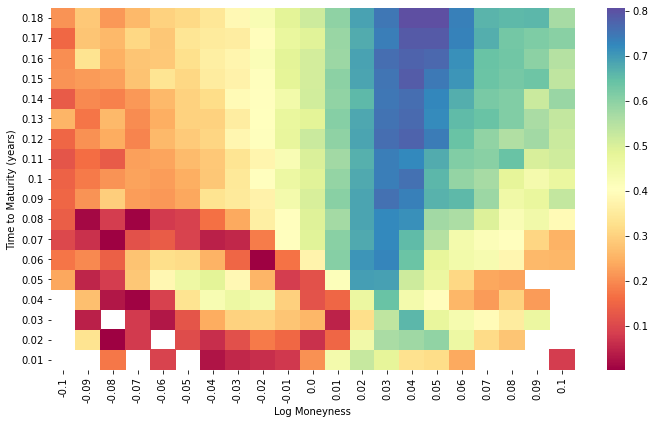

In [40]:
plot_heatmap(df, 're')

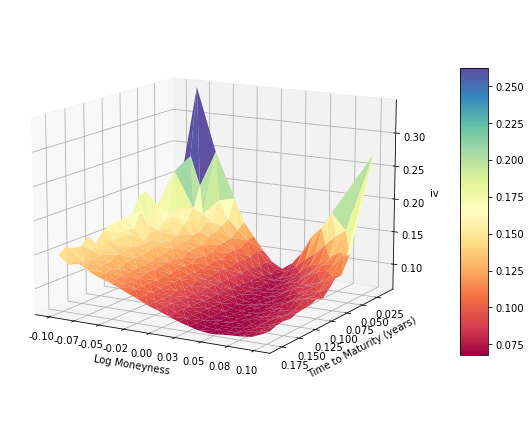

In [41]:
plot_iv_surface(df, z='iv')

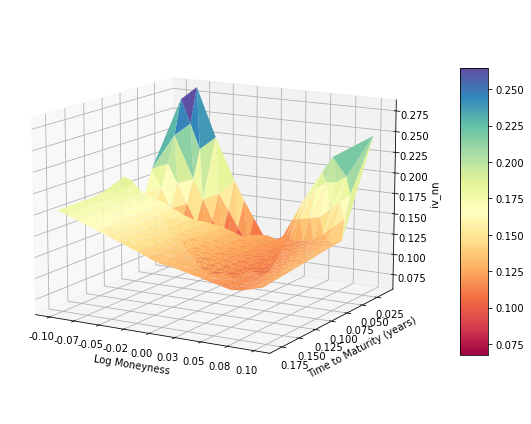

In [42]:
plot_iv_surface(df, z='iv_nn')

-----

-----

# Deep Calibration

This part implements the Deep calibration algorithm (LM combined with NN regression)

In [43]:
from utils import heston_pricer, rBergomi_pricer

Define a model parameters initializer, which will be used to initialize the model parameters before the LM calibrating loop

In [44]:
from scipy.stats import truncnorm

def model_parameters_initializer(model='heston', random_seed=None):
    """ Initialize model parameters
    """
    if model == 'heston':
        params = [
            10 * np.random.rand(), # lambda
            np.random.rand(), # vbar
            5 * np.random.rand(), # eta
            -1 * np.random.rand(), # rho
            np.random.rand() #v0
        ]
        names = ['lambda', 'vbar', 'eta', 'rho', 'v0']
    elif model == 'rbergomi' or model == 'rBergomi':
        params = [
            truncnorm.rvs(-1.2, 8.6, 0.07, 0.05), # H
            truncnorm.rvs(-3, 3, 2.5, 0.5), # eta
            truncnorm.rvs(-0.25, 2.25, -0.95, 0.2), # rho
            truncnorm.rvs(-2.5, 7, 0.3, 0.1) # v0
        ]
        names = ['H', 'eta', 'rho', 'v0']
    else:
        raise NameError("No such model name: {}".format(model))
    return params, names
params_, names_ = model_parameters_initializer(model='rBergomi', random_seed=None)
params_

[0.01580389584708944,
 2.3458895051532864,
 -0.7438779019166846,
 0.1846497358203939]

Define a function to return the prediction and the Jacobian matrix of a neural network w.r.t. a specific input

In [45]:
def predict_label_jac(sess, model, test_inputs,model_name):
    """ Use a trained model to predict and to return jacobian matrix
    """
    if model_name=='heston':
        model = keras.models.load_model('heston.h5')
    else:
        model = keras.models.load_model('rBergomi.h5')
    print("Loaded Model from disk")
    #compile and evaluate loaded model
    model.compile(optimizer='adam', loss='mean_squared_error')
    pred = model.predict(test_inputs)
    grad_func = tf.gradients(model.output, model.input)
    jac = sess.run(grad_func, feed_dict={model.input: test_inputs})[0]
    return pred, jac

In [46]:
def deep_calibration(tf_sess, nn, K_T, market_quotes, model_name='heston', lambd_init=0.1, beta0=0.25, beta1=0.75, max_iter=1000, tol=1e-8):
    """ Combines LM algorithm with a NN regressor to calibrating model parameters.
    """
    # initialize model parameters
    params, param_names = model_parameters_initializer(model_name)
    
    # initalize learning step
    lambd = lambd_init
    
    n_samples = K_T.shape[0]
    n_params = len(params)
    I = np.eye(n_params)
    Q = market_quotes.reshape((-1, 1)) # shape: [n_samples, 1]
    K_T_values = K_T.values
    
    iter_count = 0
    
    # history to store some useful information during training 
    history = {
        'delta_params': {k: [] for k in param_names},
        'R': [],
        'lambda': [],
        'c_mu': []
    }
    
    # build a input dataframe by combining K_T and model parameters
    for i in range(len(param_names)):
        K_T[param_names[i]] = params[i]
    if model_name=='heston':

        input_data = K_T[['Moneyness','Time to Maturity (years)','lambda','vbar','eta','rho','v0']].values      ##np.insert(K_T_values, [2]*n_params, params, axis=1) # shape: [n_samples, n_params+2]
    else:
        input_data = K_T[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0']].values
    
    iv_nn, J = predict_label_jac(tf_sess, nn, input_data,model_name)
    R = iv_nn - Q # shape: [n_samples, 1]
    J = J[:, 2:] # shape: [n_samples, n_params], excluding K and T
    delta_params = np.linalg.pinv(J.T.dot(J) + lambd * I).dot(J.T.dot(R)).flatten() # vector size: [n_params,]
    
    history['R'].append(np.linalg.norm(R))
    history['lambda'].append(lambd)
    for param_idx, param_name in enumerate(param_names):
        history['delta_params'][param_name].append(delta_params[param_idx])

    while iter_count < max_iter and np.linalg.norm(delta_params) > tol:
        if iter_count % 50 == 0:
            logging.info("{}/{} iteration".format(iter_count+1, max_iter))
        params_new = params - delta_params
        input_data_new = np.insert(K_T_values, [2]*n_params, params_new, axis=1)
        iv_nn_new, J_new = predict_label_jac(tf_sess, nn, input_data_new,model_name)
        R_new = iv_nn_new - Q
        J_new = J_new[:, 2:]
        R_norm = np.linalg.norm(R)
        c_mu = (R_norm - np.linalg.norm(R_new)) / (R_norm - np.linalg.norm(R - J.dot(delta_params)))
        
        history['c_mu'].append(c_mu)
        
        if c_mu <= beta0:
            # reject delta_params
            lambd *= 2 # too slow, use greater lambd
        else:
            params = params_new
            R = R_new
            J = J_new
        if c_mu >=beta1:
            lambd /= 2.0
        
        delta_params = np.linalg.pinv(J.T.dot(J) + lambd * I).dot(J.T.dot(R)).flatten() # vector size: [n_params, ]
        iter_count += 1
        
        history['R'].append(np.linalg.norm(R))
        history['lambda'].append(lambd)
        for param_idx, param_name in enumerate(param_names):
            history['delta_params'][param_name].append(delta_params[param_idx])
    if iter_count < max_iter:
        logging.info("Leave iterations after {} iters".format(iter_count))
        
    return dict(zip(param_names, params)), history

In [47]:
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

In [48]:
K_T = X_test.iloc[:500,:][['Moneyness','Time to Maturity (years)']]
K_T_origin = X_test_origin.iloc[:500, :][['Moneyness','Time to Maturity (years)']]

In [49]:
X_test.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,-0.224647,0.744120,0.327494,0.585675,0.466685,1.733288
1,2.739951,-0.231177,1.203928,-0.781822,-1.523710,-1.433830
2,0.194809,0.852408,0.301868,0.961705,0.328430,-0.642639
3,-0.795508,-0.399744,-0.610912,-0.762449,-0.402033,1.152099
4,0.782763,-0.727378,0.501113,-0.351555,-1.580655,1.428017


In [185]:
# Market parameters
S0 = 1
r = 0 

# Heston parameters 
lambd = 1.3253 
vbar = 0.0354 
eta = 0.3877 
rho = -0.7165 
v0 = 0.0174 
q = 0

market_quotes = np.array([heston_pricer(lambd, vbar, eta, rho, v0, r, q, K_T_origin.iloc[i, 1], S0, K_T_origin.iloc[i, 0])[1] for i in range(K_T.shape[0])])
market_quotes = market_quotes.reshape((-1, 1))

In [50]:
K_T_origin.head()

,Moneyness,Time to Maturity (years)
0,1.064951,0.498520
1,0.968319,0.742324
2,1.075680,0.491391
3,0.951618,0.237476
4,0.919156,0.546817


In [52]:
# df.progress_apply(lambda row: rBergomi_pricer(row['H'], row['eta'], row['rho'], row['v0'], 
#                                                          row['Time to Maturity (years)'], row['Moneyness'], 1.0)[1], 
#                              axis=1)

S0 = 1                            
eta = 1.9
rho = -0.9
H = 0.07
v0 = 0.01
market_quotes = np.array([rBergomi_pricer(H, eta, rho, v0, K_T_origin.iloc[i, 1], K_T_origin.iloc[i, 0], S0)[1] for i in range(K_T.shape[0])])
market_quotes = market_quotes.reshape((-1, 1))

In [53]:
valid_idx = ~np.isnan(market_quotes.flatten())
K_T_input = K_T.iloc[valid_idx, :]
market_quotes = market_quotes[valid_idx, :]

In [54]:
K_T.columns

Index(['Moneyness', 'Time to Maturity (years)'], dtype='object')

In [55]:
import keras as K
import keras
params, history = deep_calibration(sess, model, K_T_input, market_quotes, model_name='rbergomi', lambd_init=0.01, beta0=0.25, beta1=0.75, max_iter=1000)

D:\Anaconda3\envs\tf2_cpu\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gaolzhu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-01-27 23:39:38,778 - INFO - 1/1000 iteration


Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk


2022-01-27 23:40:06,383 - INFO - Leave iterations after 38 iters


In [56]:
# Heston parameters 
# eta = 0.3877 
# rho = -0.7165 
# lambd = 1.3253 
# vbar = 0.0354 
# v0 = 0.0174 

# rBergomi parameters
# eta = 1.9
# rho = -0.9
# H = 0.07
# v0 = 0.01

params

{'H': 0.062107083521383416,
 'eta': 3.156185292838522,
 'rho': -0.9694770075975714,
 'v0': 0.27925482050052003}

In [61]:
mu_hat = pd.DataFrame([params.values()], columns=params.keys())
mu_hat['Moneyness'] = 0
mu_hat['Time to Maturity (years)'] = 0
SCALER.inverse_transform(mu_hat[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0']])


,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.088174,0.991224,0.407418,3.868866,-0.941099,0.111715


In [63]:
X_train_origin.describe()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
count,263631.000000,263631.000000,263631.000000,263631.000000,263631.000000,263631.000000
mean,0.085449,0.991224,0.407418,2.390472,-0.850865,0.098658
std,0.043872,0.099079,0.278178,0.468412,0.093075,0.046758
min,0.016279,0.750001,0.002746,1.321552,-0.997984,0.008528
25%,0.050548,0.920092,0.175483,2.033332,-0.921414,0.059954
50%,0.082638,0.992150,0.331713,2.421584,-0.851942,0.080881
75%,0.111747,1.064577,0.635445,2.793560,-0.759685,0.152528
max,0.205656,1.199986,0.999989,3.367068,-0.598632,0.231830


In [64]:
X_train.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.782763,-0.509980,-1.316150,-0.351555,-1.580655,1.428017
1,-1.122477,-0.438684,-0.031326,-1.585436,0.151045,1.405011
2,1.574964,0.041318,-0.506668,1.674728,-0.246680,0.340468
3,0.050864,-0.257134,-0.562674,0.261504,-0.298577,-0.971038
4,0.604307,0.161745,-0.349342,0.860542,1.035707,0.215226


In [65]:
class FeatureScaler(object):
    def __init__(self, train):
        self.mean = train.mean(axis=0)
        self.std = train.std(axis=0)
    
    def transform(self, df):
        return (df - self.mean) / self.std
    
    def inverse_transform(self, df):
        return df * self.std + self.mean
    
    def get_params(self):
        return self.mean, self.std

SCALER.get_params()

(H                           0.085449
 Moneyness                   0.991224
 Time to Maturity (years)    0.407418
 eta                         2.390472
 rho                        -0.850865
 v0                          0.098658
 dtype: float64,
 H                           0.043872
 Moneyness                   0.099079
 Time to Maturity (years)    0.278178
 eta                         0.468412
 rho                         0.093075
 v0                          0.046758
 dtype: float64)